In [1]:
# -*- coding: utf-8 -*-
#  File: OTUS_PRO_HW2.ipynb
#  Project: 'OTUS PRO Homework #2'
#  Created by Gennady Matveev (gm@og.ly) on 08-01-2022.
#  Attributions: Silhuette_score calculation and plotting
#  adapted in part from sklearn documentation

# **$Homework$** **$2$**  
**OTUS Machine Learning Professional**

Goals:   
- Apply k-means, hierarhical и DBSCAN clustering methods to "German Credit Risk" dataset
- Find optimal number of clusters with Elbow method and Silhouette plot
- Try feature space compression with PCA, UMAP and tSNE, visualize data in 2D
- Interpret results: cluster means etc.
- Find differences in clusters with boxplots of features

Means:  
- All meaningful programming will be done in sklearn
- ATOM library is used for preprocessing  
https://tvdboom.github.io/ATOM/about/

Dataset:
- German Credit Risk 
https://www.kaggle.com/uciml/german-credit

Abbreviations:
- EDA: exploratory data analysis
- H/P: hyperparameters

<a href="https://colab.research.google.com/github/oort77/OTUS_PRO_HW2/blob/main/otus_pro_hw2_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

### Google colab specific part

Please uncomment and run the cell below to install dependencies.  
Dependencies installation fails at the first attempt, please restart runtime when promted and run all again.

In [2]:
# !pip install -r 'https://drive.google.com/uc?export=download&id=15OarhUWwc7YnxvBPVvzYtLDKsoz0Sdz3'

### Import libraries and setup notebook

In [3]:
import pandas as pd
import numpy as np
from atom import ATOMClassifier
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
# UMAP, TSNE
import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler, FunctionTransformer
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from tqdm import tqdm
from time import sleep
from IPython.core.display import display, HTML
import warnings

#### Miscellaneius settings 

In [4]:
%matplotlib inline
display(HTML("<style>.container {width:80% !important; }</style>"))
%config InlineBackend.figure_format = 'retina'
# plt.rcParams["figure.figsize"]=(12,4)
sns.set(rc={'figure.figsize': (12, 4)})
warnings.filterwarnings("ignore")
pd.options.display.precision = 4

#### ML parameters

In [5]:
random_state = 17
njobs = 6
models = ["DBSCAN", "KMeans", "AgglomerativeClustering"]

### Load data

In [6]:
data = pd.read_csv("https://drive.google.com/uc?export=download&id=1Ab-pu0jfDDd9fwLDypziYmodD5k-bVpi",
                   compression="zip", index_col=0)
data.head()

Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  
0         6             radio/TV  
1        48             radio/TV  
2        12            education  
3        42  furniture/equipment  
4        24                  car

### EDA

#### Basic

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


In [8]:
data.describe().T

count      mean        std    min     25%     50%      75%  \
Age            1000.0    35.546    11.3755   19.0    27.0    33.0    42.00   
Job            1000.0     1.904     0.6536    0.0     2.0     2.0     2.00   
Credit amount  1000.0  3271.258  2822.7369  250.0  1365.5  2319.5  3972.25   
Duration       1000.0    20.903    12.0588    4.0    12.0    18.0    24.00   

                   max  
Age               75.0  
Job                3.0  
Credit amount  18424.0  
Duration          72.0

#### Run profile report on the dataset

In [9]:
data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Pipeline

#### Preprocessing

In [10]:
atom = ATOMClassifier(data, n_jobs=njobs, test_size=0.2,
                      verbose=1, warnings=False, random_state=random_state)

<< ================== ATOM ================== >>
Algorithm task: multiclass classification.
Parallel processing with 4 cores.

Dataset stats ==================== >>
Shape: (1000, 9)
Scaled: False
Missing values: 577 (6.4%)
Categorical features: 4 (50.0%)
Outlier values: 34 (0.5%)
-------------------------------------
Train set size: 800
Test set size: 200
-------------------------------------



In [11]:
log_cols = ["Age", "Credit amount", "Duration"]


def log_transform(x):
    return np.log1p(x + 1)


log_transformer = FunctionTransformer(log_transform)

In [12]:
from sklearn.preprocessing import KBinsDiscretizer
kb = KBinsDiscretizer(n_bins=5, encode="onehot", strategy="quantile")

In [13]:
atom.impute(strat_cat="unknown")
atom.clean(drop_min_cardinality=False)
atom.encode()  # frac_to_other=0.05)
atom.add(log_transformer, columns=log_cols)
# atom.add(kb, columns = log_cols)
atom.add(StandardScaler())
atom.gauss()  # ?
# atom.add(kb, columns = log_cols)

Fitting Imputer...
Imputing missing values...
Applying data cleaning...
Fitting Encoder...
Encoding categorical columns...
Fitting FunctionTransformer...
Applying FunctionTransformer to the dataset...
Fitting StandardScaler...
Applying StandardScaler to the dataset...
Making features Gaussian-like...


#### Have a look at the transformed dataset

In [14]:
atom.X.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
X = atom.X
X.head()

Age     Sex     Job  Housing_own  Housing_rent  Housing_free  \
0  0.6346 -0.6722  0.0709        0.643       -0.4764       -0.3471   
1 -0.5927 -0.6722  0.0709        0.643       -0.4764       -0.3471   
2 -1.2232 -0.6722 -1.3357        0.643       -0.4764       -0.3471   
3 -1.4051 -0.6722  0.0709        0.643       -0.4764       -0.3471   
4  0.2180 -0.6722  0.0709        0.643       -0.4764       -0.3471   

   Saving accounts_quite rich  Saving accounts_moderate  \
0                      3.8730                   -0.3448   
1                     -0.2582                    2.9003   
2                     -0.2582                   -0.3448   
3                     -0.2582                   -0.3448   
4                     -0.2582                   -0.3448   

   Saving accounts_little  Saving accounts_unknown  Saving accounts_rich  \
0                 -1.2058                  -0.4863               -0.2233   
1                 -1.2058                  -0.4863               -0.2233   
2                  0.8293                  -0.4863               -0.2233   
3                  0.8293                  -0.4863               -0.2233   
4                 -1.2058                   2.0564               -0.2233   

   Checking account_unknown  Checking account_rich  Checking account_little  \
0                    1.2344                -0.2717                  -0.6217   
1                   -0.8101                 3.6804                  -0.6217   
2                   -0.8101                -0.2717                   1.6086   
3                   -0.8101                 3.6804                  -0.6217   
4                    1.2344                -0.2717                  -0.6217   

   Checking account_moderate  Credit amount  Duration  
0                     -0.587         0.1731    0.3403  
1                     -0.587        -0.7730   -1.7882  
2                     -0.587        -0.3894    0.4975  
3                     -0.587         0.6470    1.2457  
4                     -0.587        -1.2044   -0.7095

### KMeans

#### Find the optimal number of clusters - Elbow method

In [16]:
def elbow_study(k_max: int):
    inertia = []
    with tqdm(total=k_max*10) as pbar:
        for k in range(1, k_max+1):
            X_km = KMeans(n_clusters=k).fit(X)
            inertia.append(np.sqrt(X_km.inertia_))
            sleep(0.1)
            pbar.update(10)
#     plt.figure()
    plt.plot(range(1, k_max+1), inertia, marker="s")
    plt.title("The Elbow Method using Inertia")
    plt.xlabel("Number of clusters, k")
    plt.ylabel("Inertia")
    plt.show()

    d = {}
    for k in range(2, k_max-1):
        i = k-1
        d[k] = (inertia[k-1]-inertia[k])/(inertia[k-2]-inertia[k-1])
#     plt.figure(figsize=(12, 4))
    plt.plot(range(2, k_max-1), [x for x in d.values()], marker="s")
    plt.title("The Elbow Method using Inertia")
    plt.xlabel("Number of clusters, k")
    plt.ylabel("Comparative decrease in inertia")
    plt.vlines(10, 0, 3, colors="g", linestyles="dashed")
    plt.hlines(0.2357, 0, k_max, colors="r", linestyles="dashed")
    plt.show()

    key_min = min(d.keys(), key=(lambda k: d[k]))
    print(f"Min Elbow score is {d[key_min]:.4f} for n_clusters={key_min}")

100%|██████████| 200/200 [00:04<00:00, 49.52it/s]


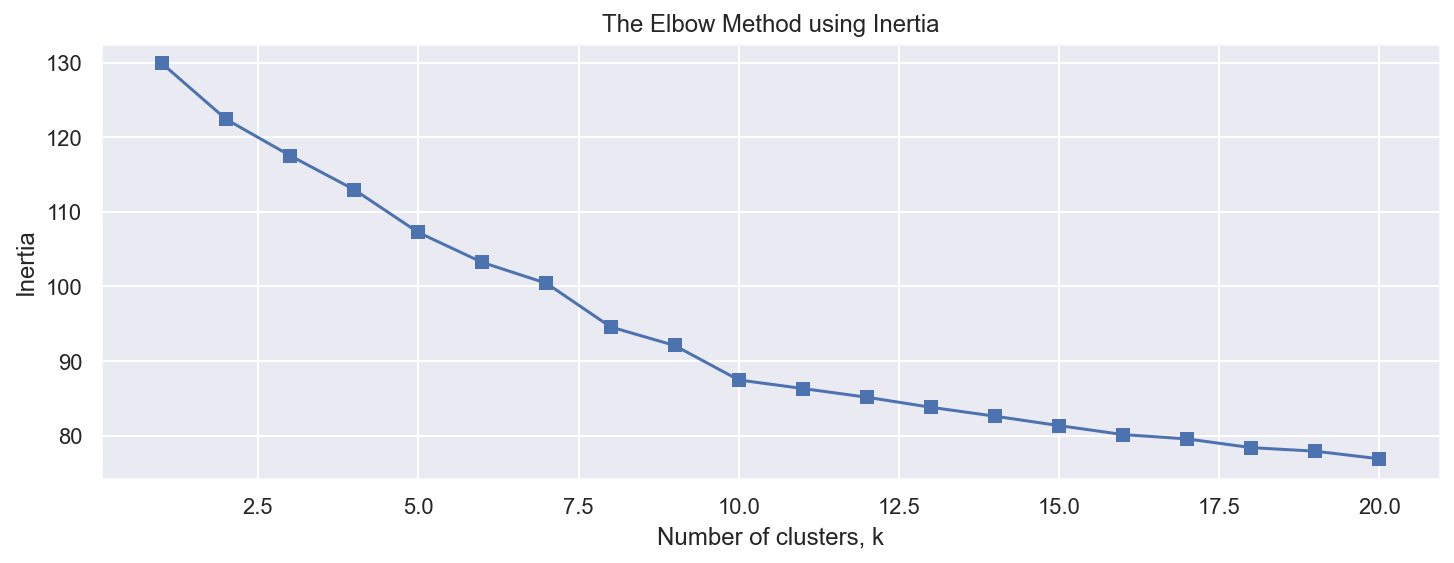

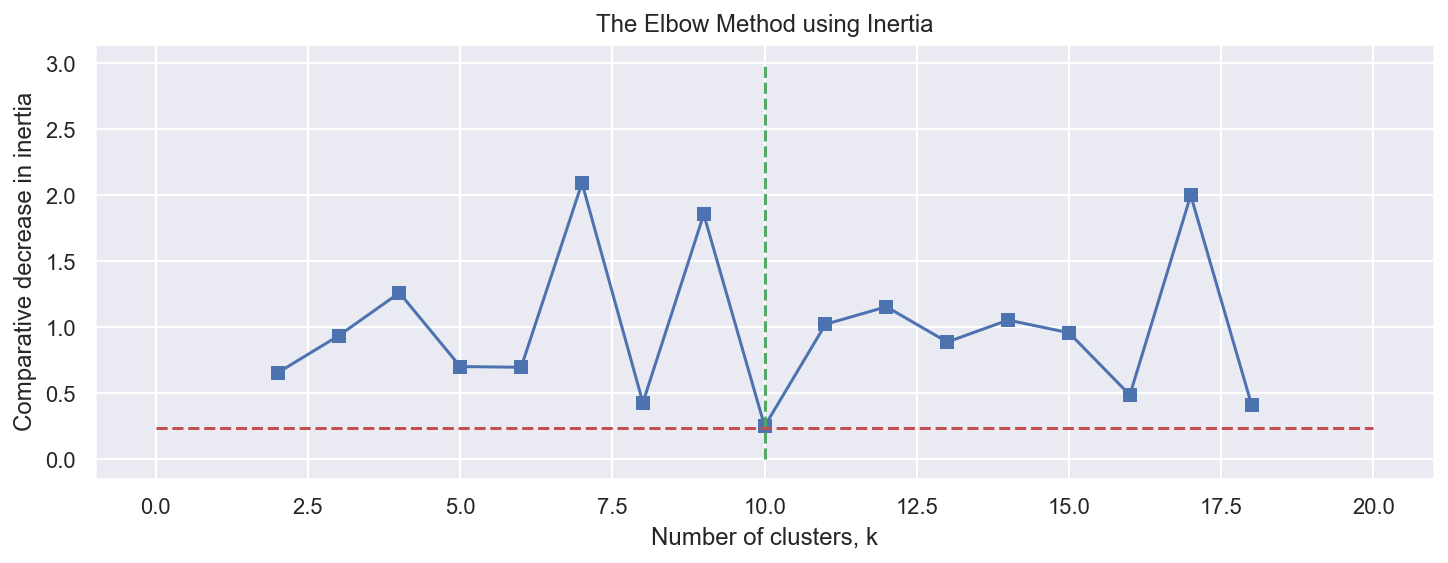

Min Elbow score is 0.2476 for n_clusters=10


In [17]:
elbow_study(20)

We can see that the optimal number of clusters is 10.

#### Find the optimal number of clusters - Silhuette plot

In [18]:
def silhuette_study(n_min: int = 2, n_max: int = 21):
    range_n_clusters = range(n_min, n_max+1)
    scores = {}
    silhuette_min = {}
    for n_clusters in range_n_clusters:
        fig, ax1 = plt.subplots()  # figsize=(10,4)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            f"For n_clusters = {n_clusters:2d} the average silhouette_score is : {silhouette_avg:.4f}")
        scores[n_clusters] = silhouette_avg
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        y_lower = 10
        has_negative_values = 1
        silhuette_min[n_clusters] = 1

        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # 10 for the 0 samples
            # Find min value of Silhuette score in n_clusters
            if min(ith_cluster_silhouette_values) < silhuette_min[n_clusters]:
                silhuette_min[n_clusters] = min(ith_cluster_silhouette_values)
        ax1.set_title(f"Silhouette plot for {i+1} clusters.")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="dashed")
        ax1.text(0.805, 40, f"Score = {silhouette_avg:.4f}")
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

    # Best silhouette_avg
    key_max = max(scores.keys(), key=(lambda k: scores[k]))
    # +n_min
    print(
        f"Max silhuette score is {scores[key_max]:.4f} for n_clusters = {key_max}\n")

    print("""Let's find the number of clusters with max value 
    of min Silhuette score, i.e. with minimum overlap.\n""")
    _, ax = plt.subplots()
    lists = sorted(silhuette_min.items())
    x, y = zip(*lists)
    plt.plot(x, y)
    plt.axvline(9, c="g", linestyle="--")
    plt.axhline(-0.006, c="r", linestyle="--")
    ax.set_xlim([0, n_max+1])
    plt.suptitle("Min values of Silhuette score for n_clusters")
    plt.show()

For n_clusters =  2 the average silhouette_score is : 0.1679
For n_clusters =  3 the average silhouette_score is : 0.1521
For n_clusters =  4 the average silhouette_score is : 0.1720
For n_clusters =  5 the average silhouette_score is : 0.1975
For n_clusters =  6 the average silhouette_score is : 0.1741
For n_clusters =  7 the average silhouette_score is : 0.1750
For n_clusters =  8 the average silhouette_score is : 0.1823
For n_clusters =  9 the average silhouette_score is : 0.2282
For n_clusters = 10 the average silhouette_score is : 0.2293
For n_clusters = 11 the average silhouette_score is : 0.2352
For n_clusters = 12 the average silhouette_score is : 0.2264
For n_clusters = 13 the average silhouette_score is : 0.2527
For n_clusters = 14 the average silhouette_score is : 0.2360
For n_clusters = 15 the average silhouette_score is : 0.2454
For n_clusters = 16 the average silhouette_score is : 0.2485
For n_clusters = 17 the average silhouette_score is : 0.2189
For n_clusters = 18 the 

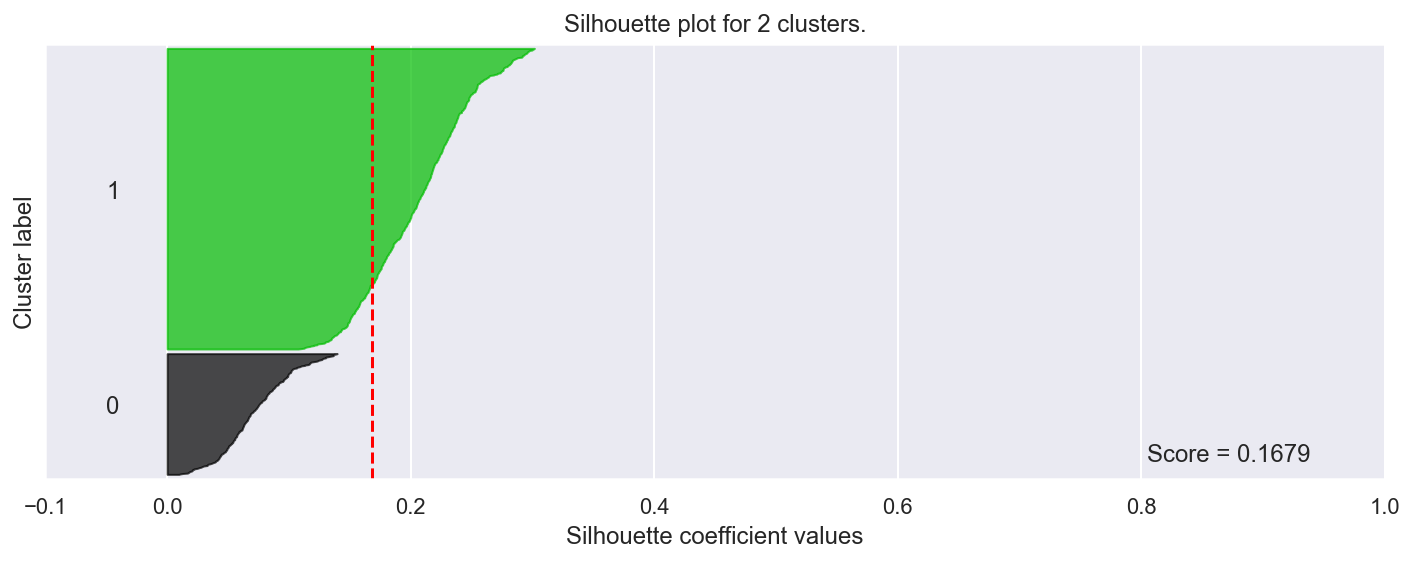

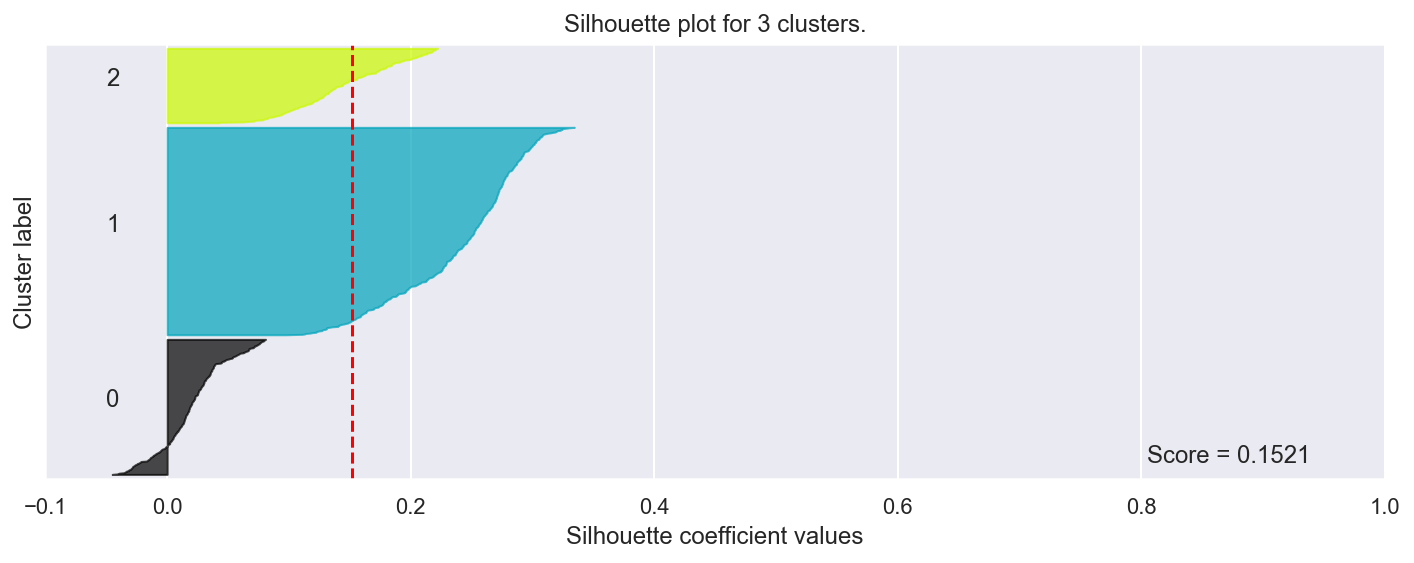

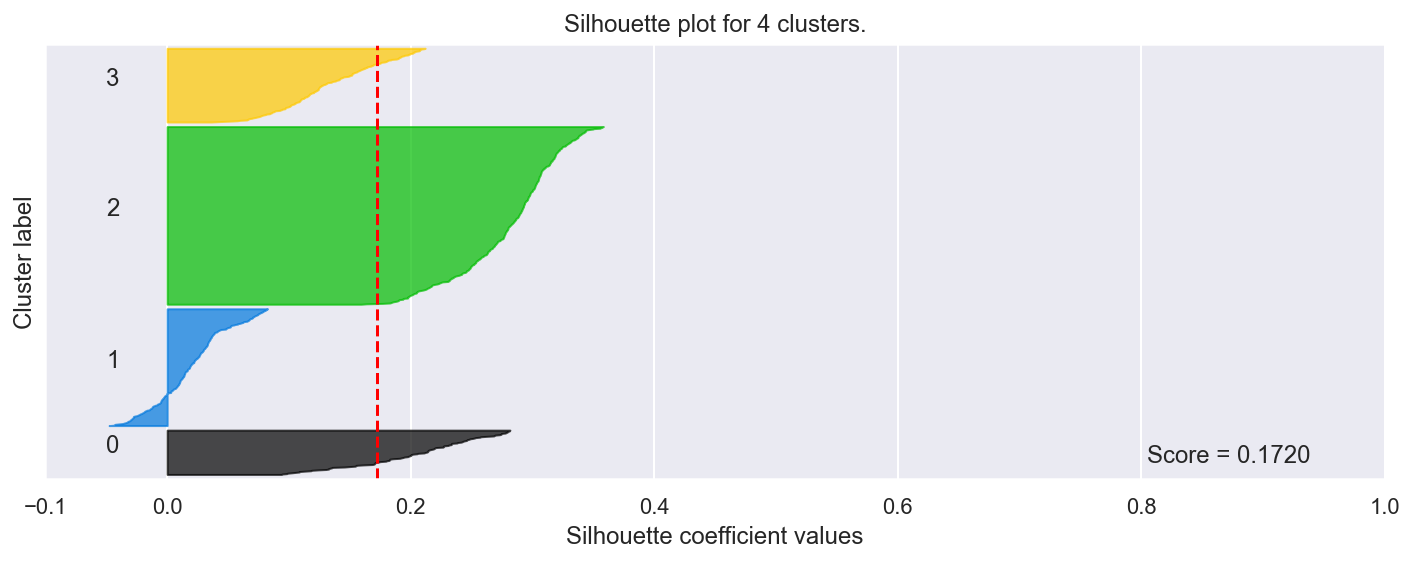

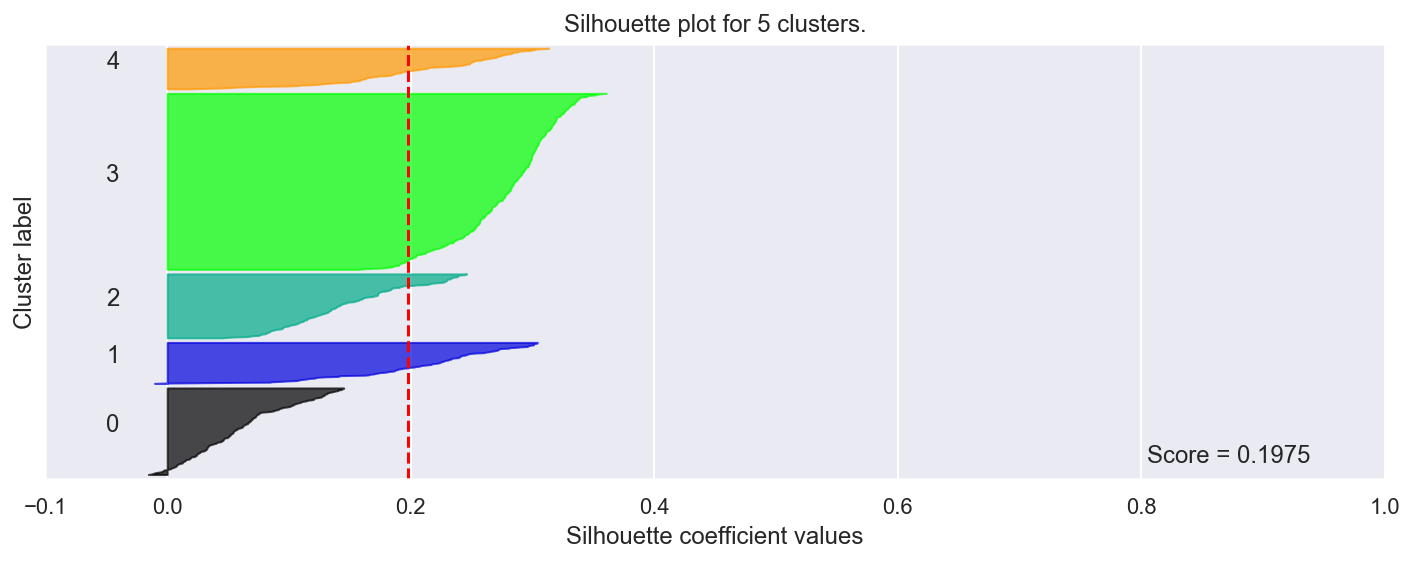

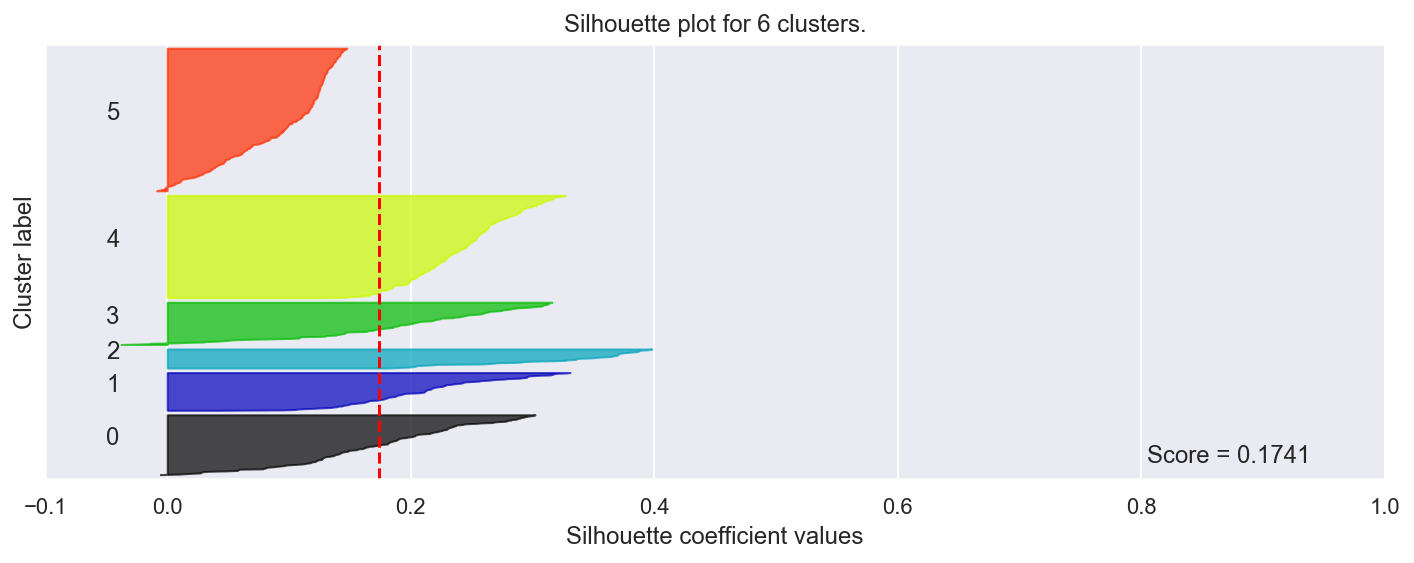

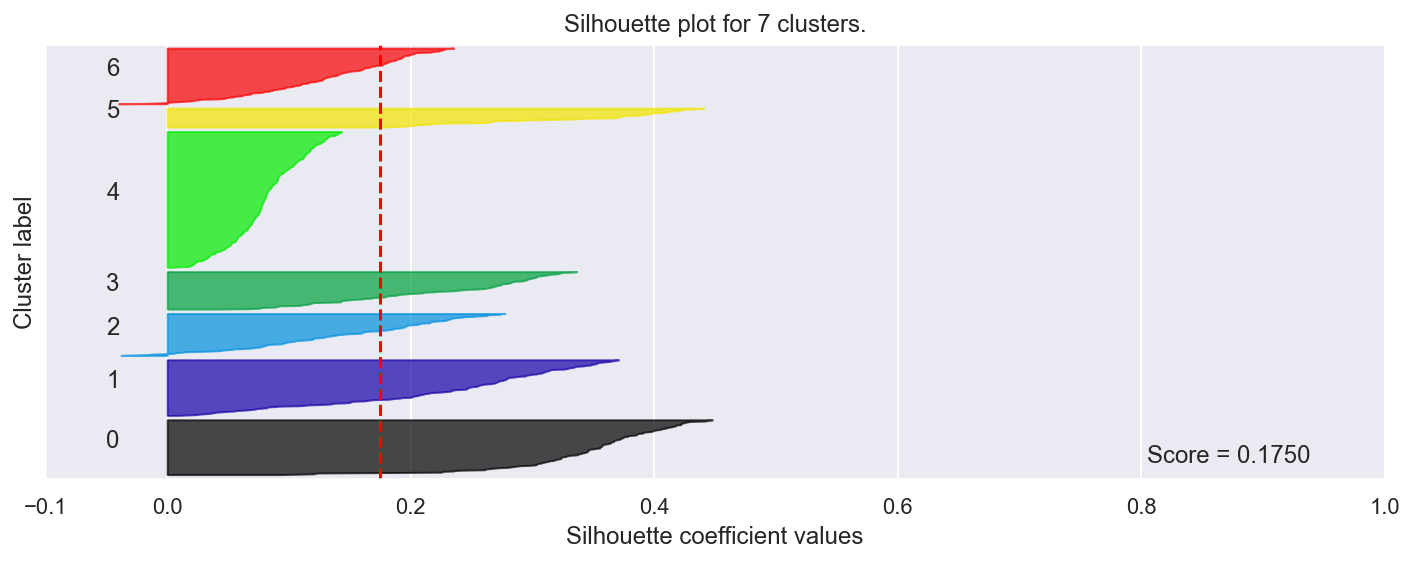

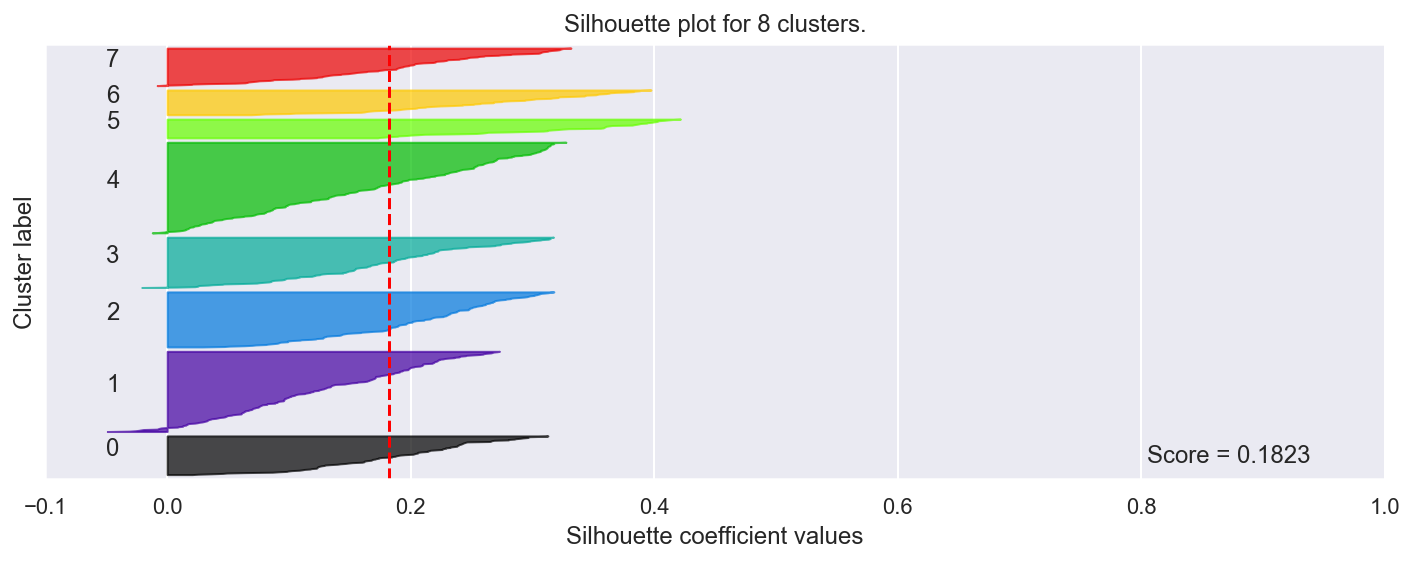

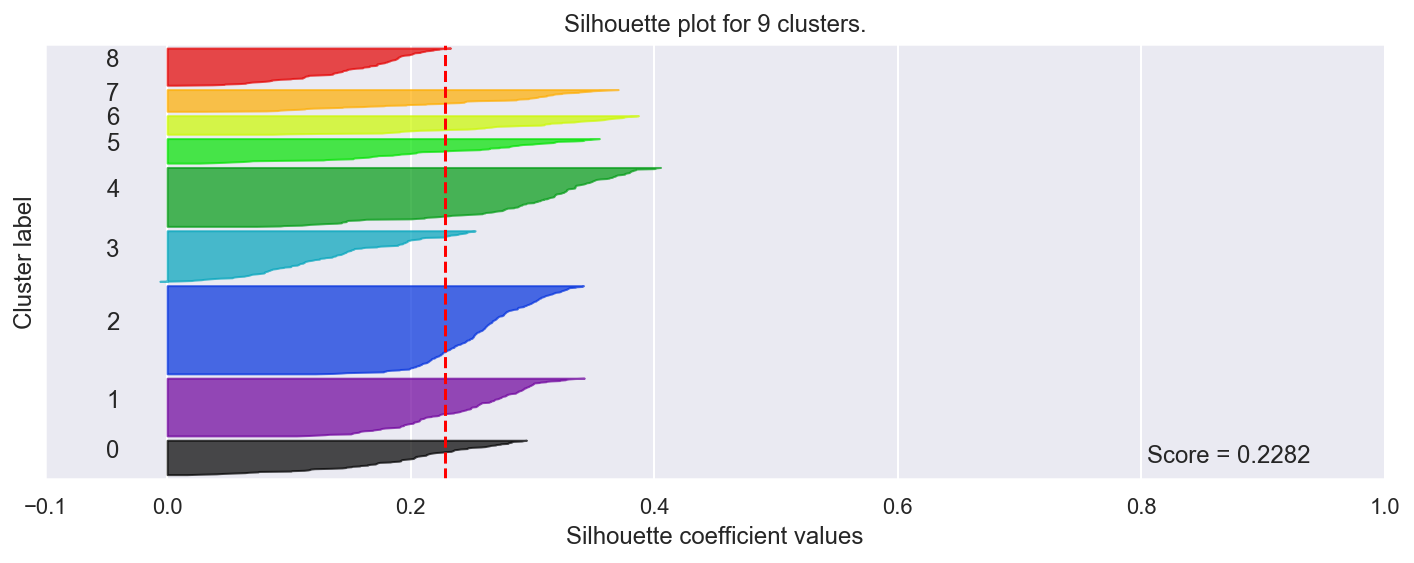

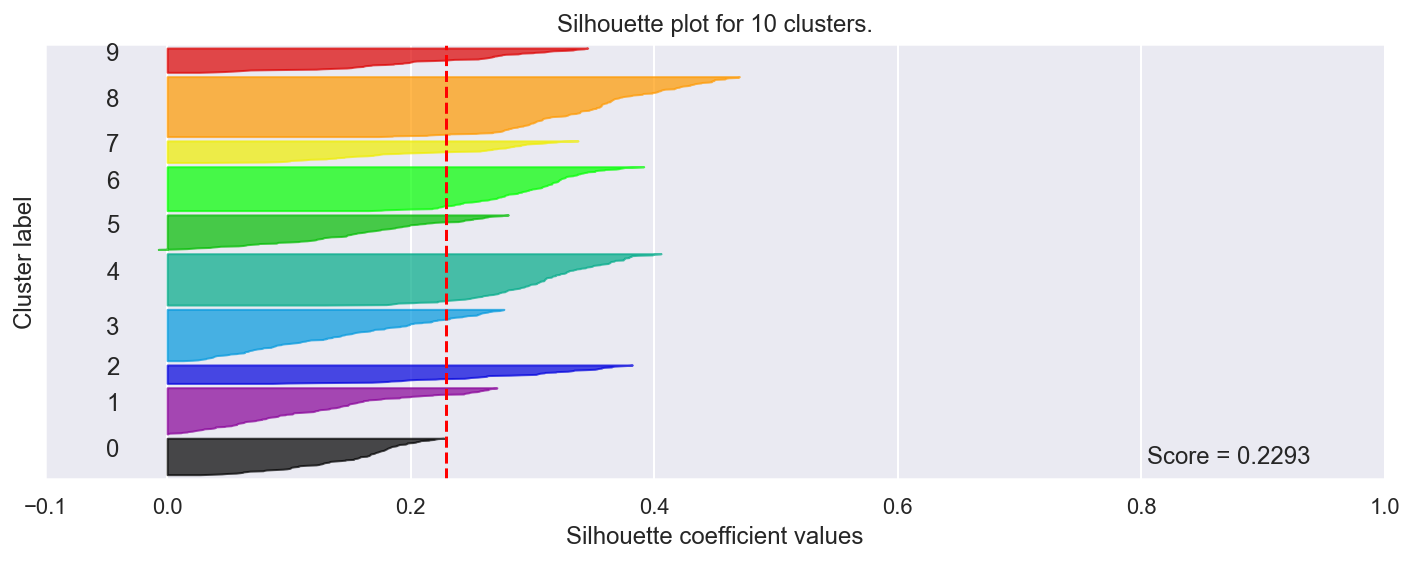

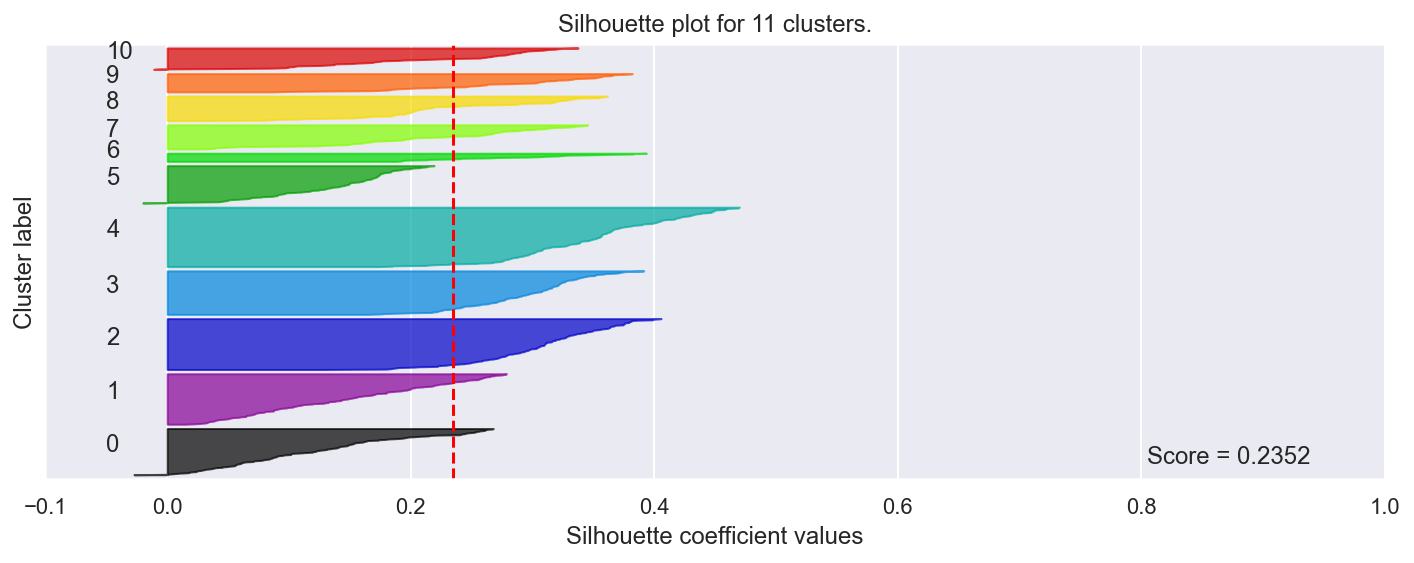

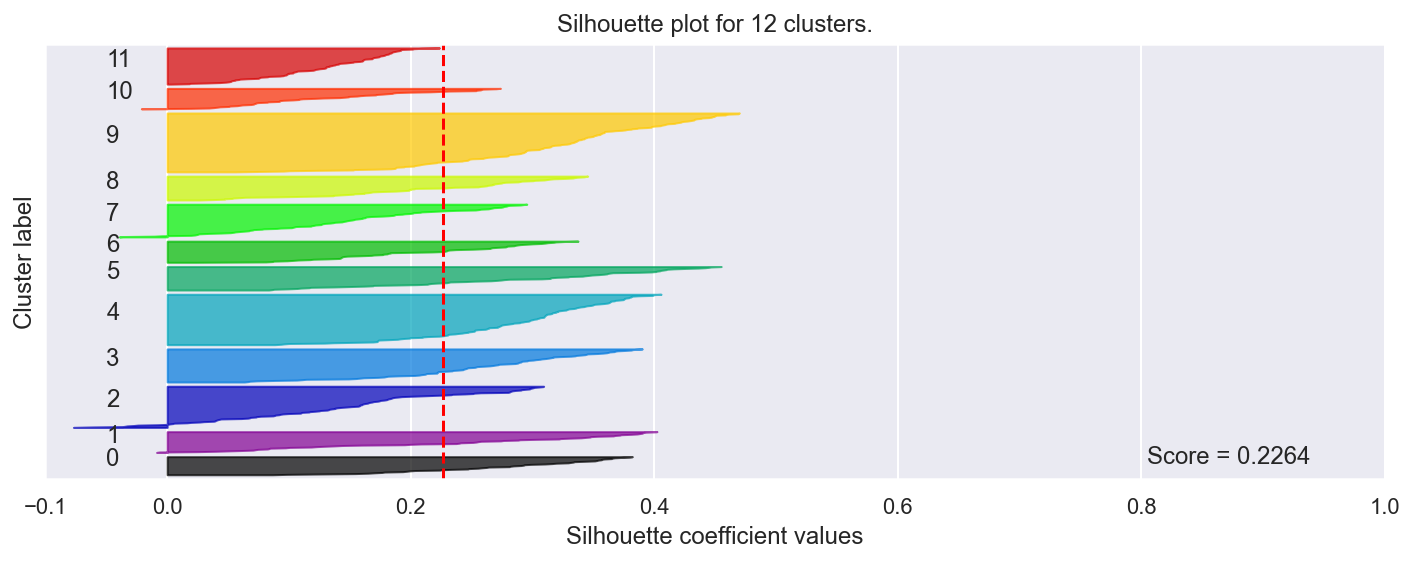

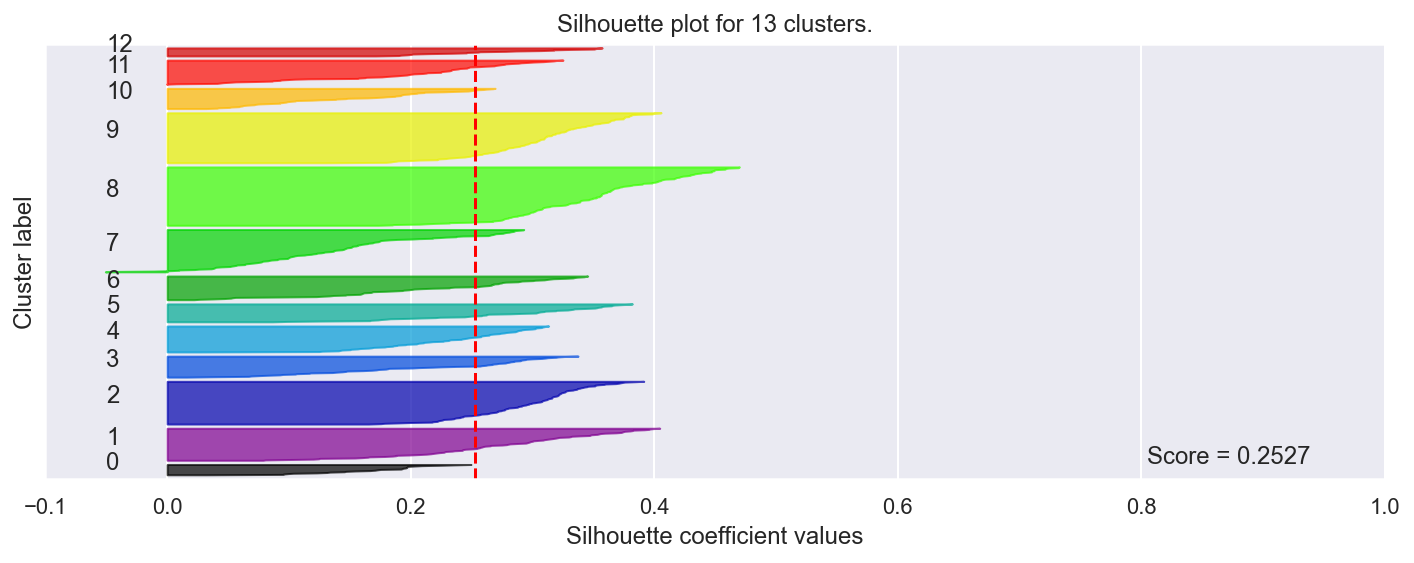

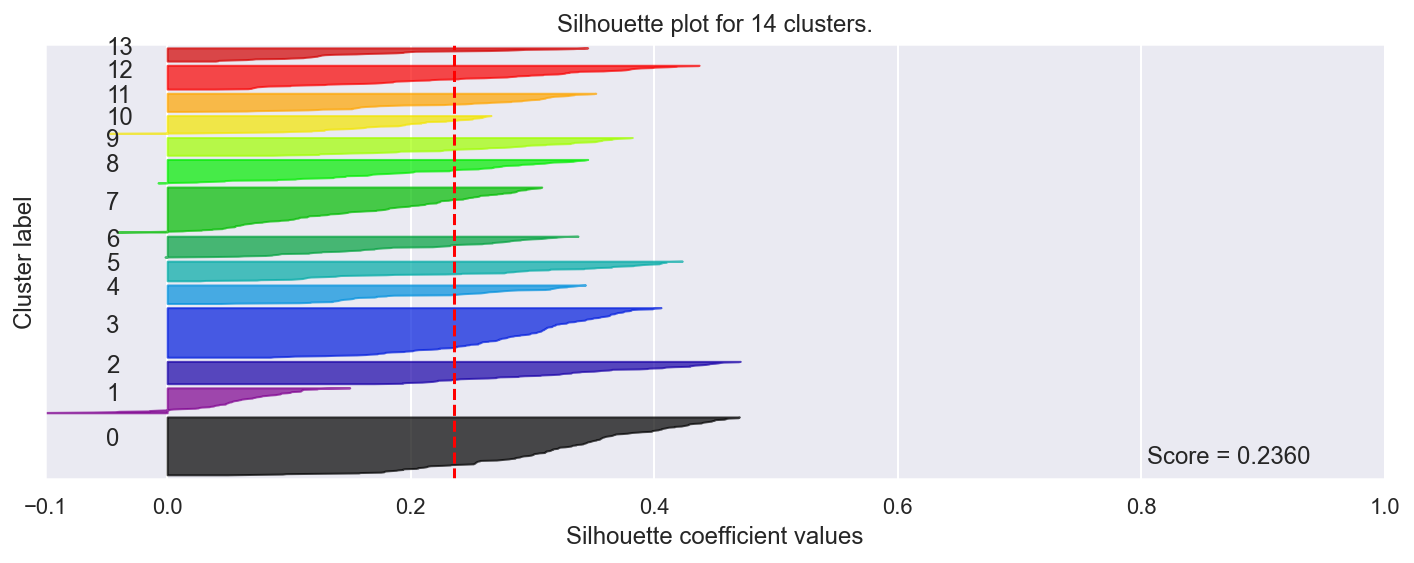

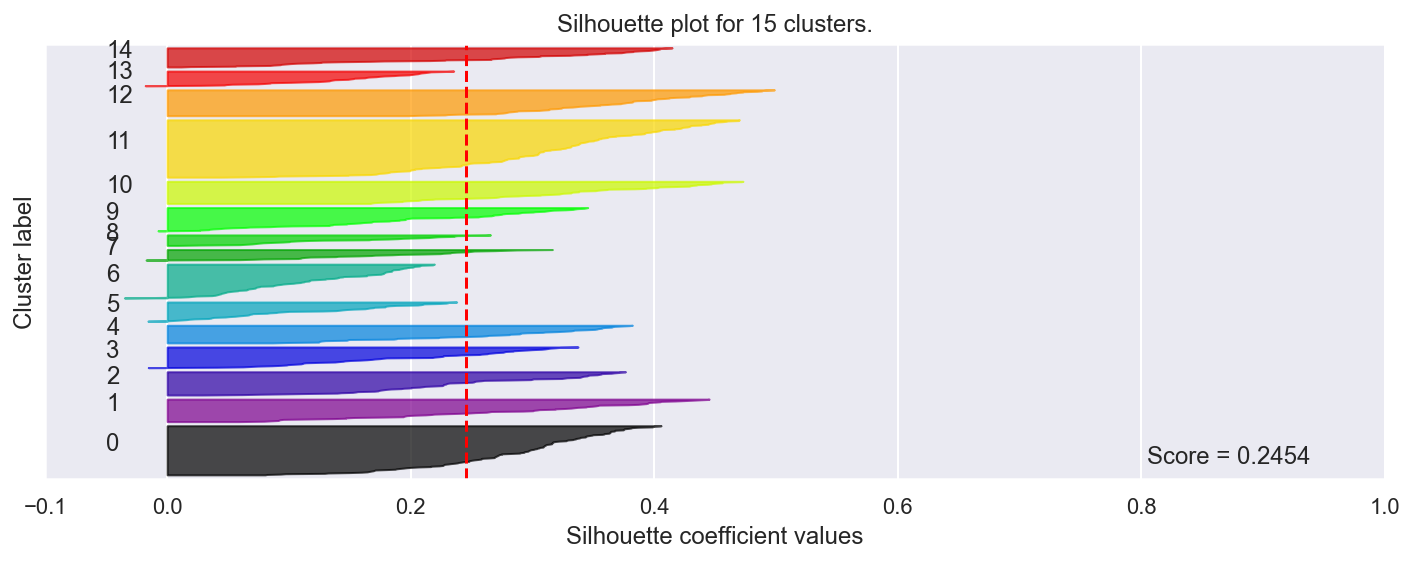

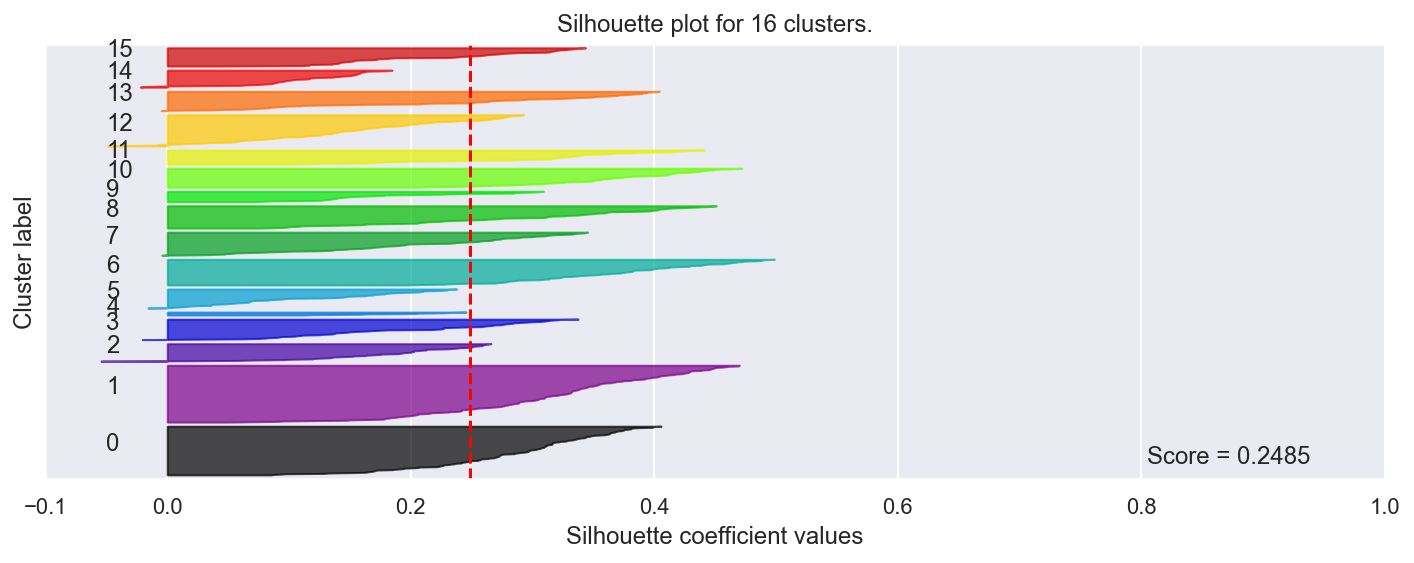

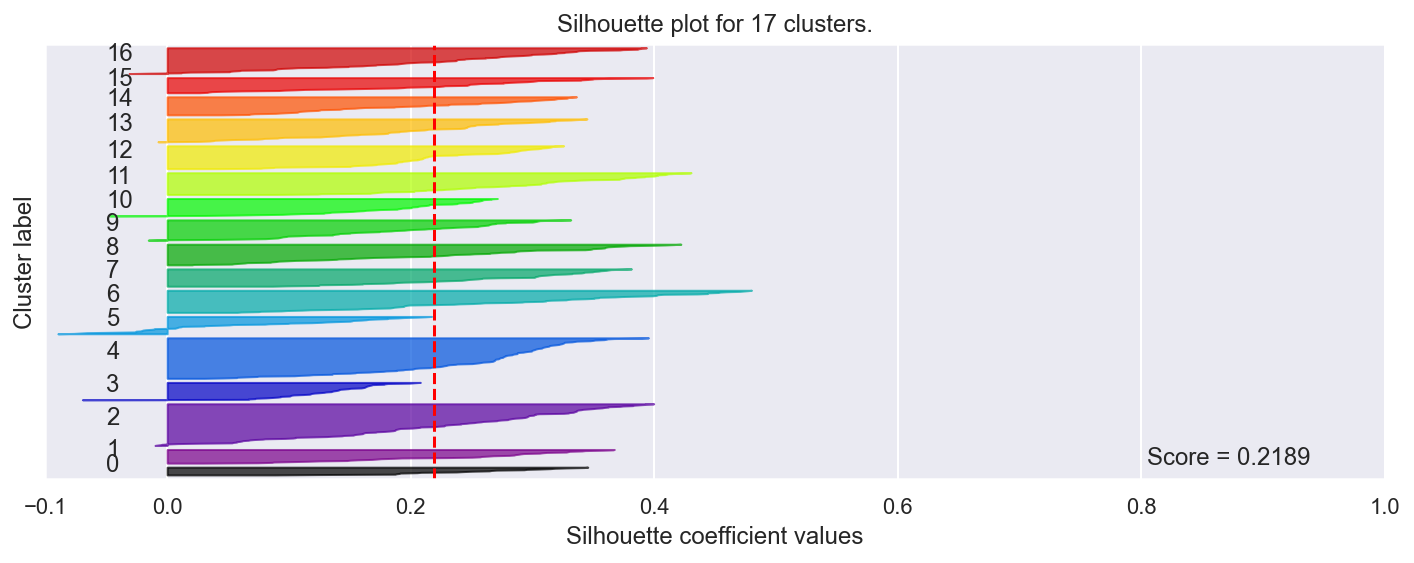

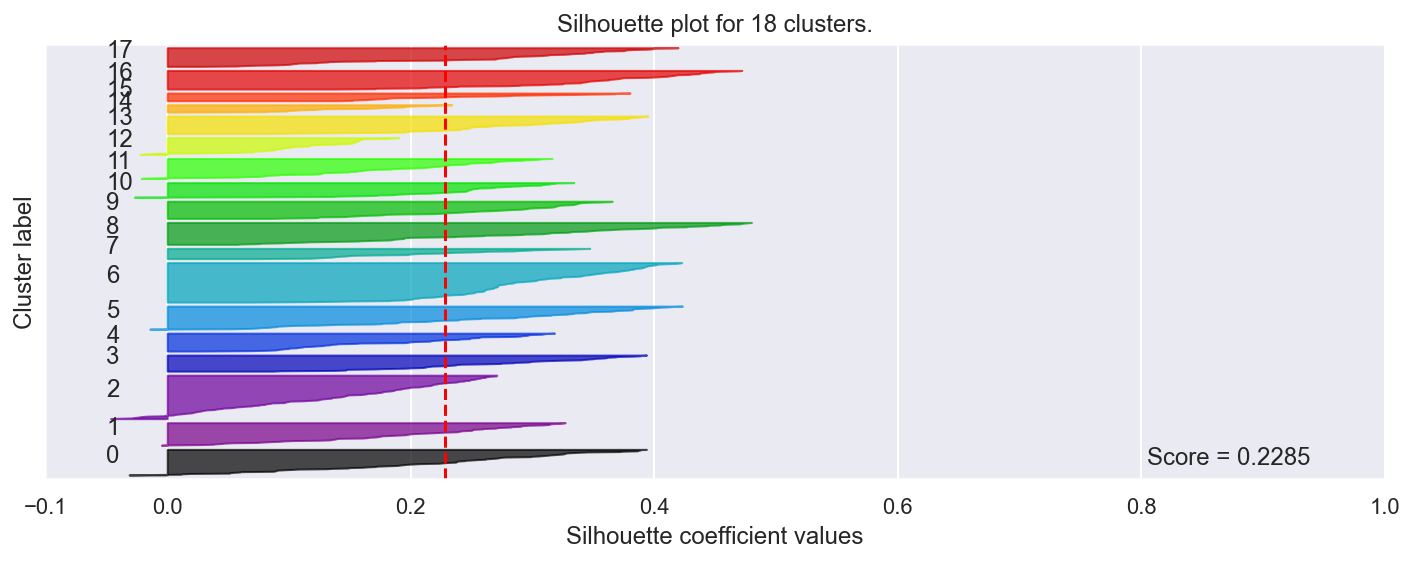

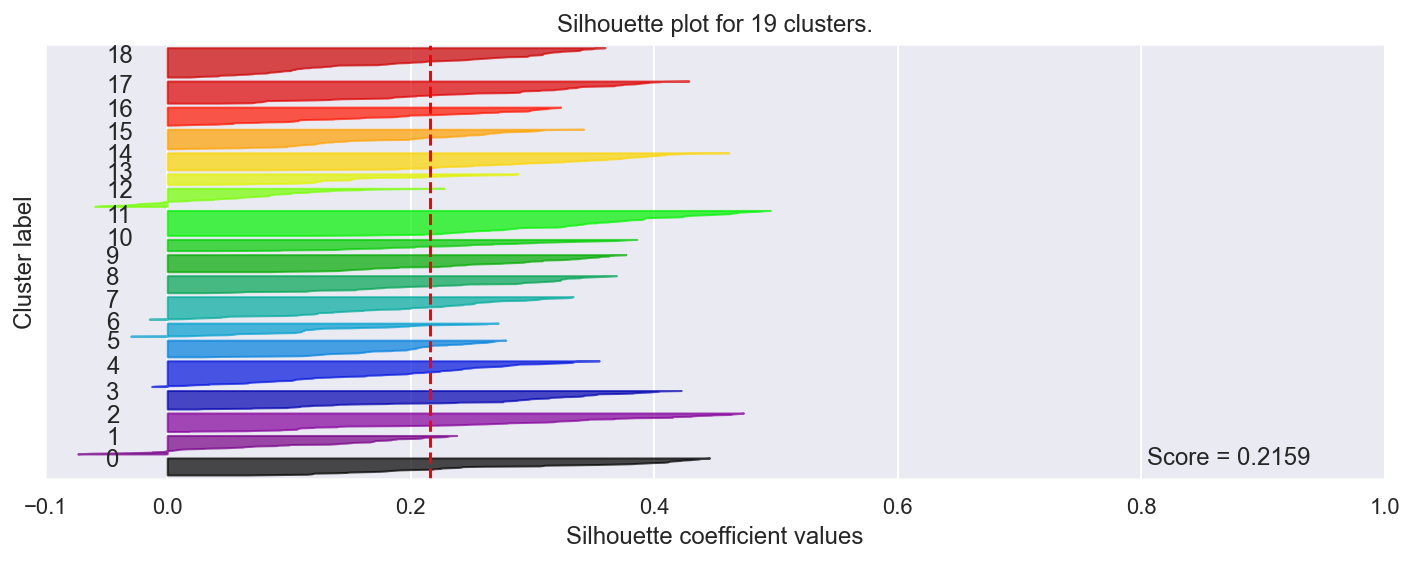

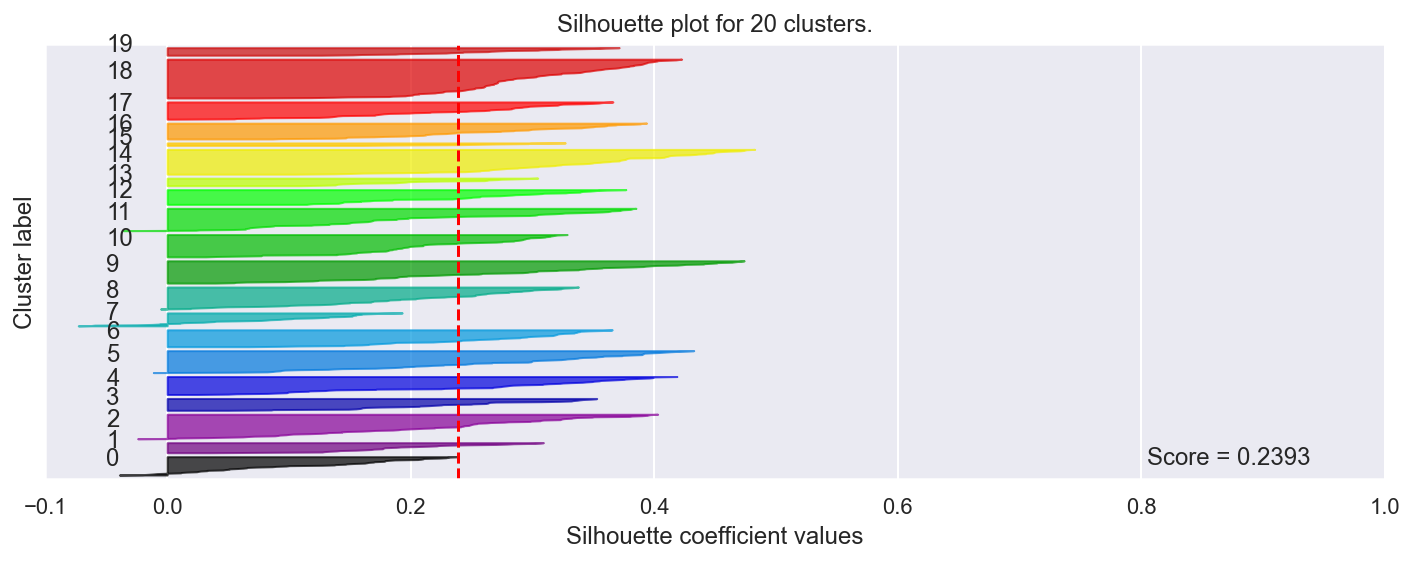

Max silhuette score is 0.2527 for n_clusters = 13

Let's find the number of clusters with max value of min Silhuette score,  
    i.e. with minimum overlap.



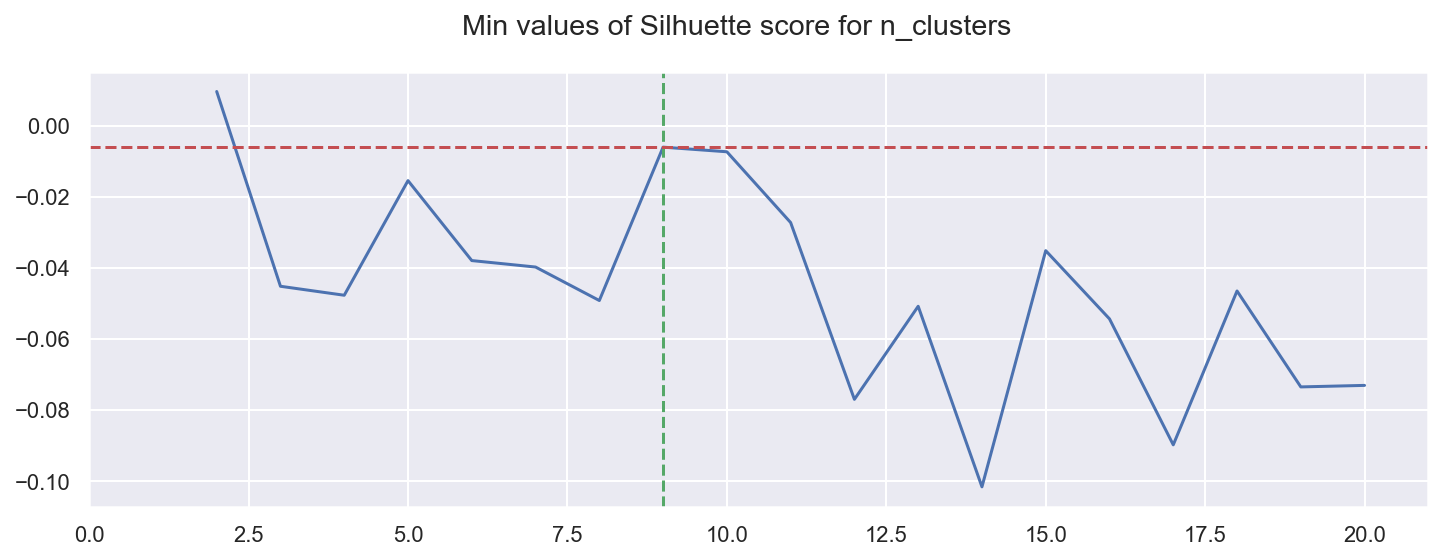

In [19]:
silhuette_study(2, 20)

The silhuette score is the highest for n_clusters=13, although negative values of Silhoutte score indicate presence of misclassifications. Taking into account minimal clusters' overlap, the optimal values for n_clusters are 9 and 10.

### Dimensionality reduction - PCA, UMAP, T-SNE

In [20]:
def dim_reduction(X, dim_reduction=PCA(), n_clusters=4):
    # Before:
    kmeans = KMeans(n_clusters=n_clusters)
    X_clust = kmeans.fit_transform(X)

    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)  # figsize=(12,4),
    ax[0].scatter(X_clust[:, 0], X_clust[:, 1], s=20,
                  c=kmeans.labels_.astype(float), cmap="coolwarm")
    ax[1].scatter(X_clust[:, 0], X_clust[:, 2], s=20,
                  c=kmeans.labels_.astype(float), cmap="coolwarm")
    ax[2].scatter(X_clust[:, 1], X_clust[:, 2], s=20,
                  c=kmeans.labels_.astype(float), cmap="coolwarm")
    plt.suptitle(
        f"Before: scatterplot of the first three features (X0, X1, and X2) in {n_clusters} clusters")
    ax[0].set_xlabel("X0")
    ax[0].set_ylabel("X1")
    ax[1].set_xlabel("X0")
    ax[1].set_ylabel("X2")
    ax[2].set_xlabel("X1")
    ax[2].set_ylabel("X2")
    plt.show()

    # After
    X_transf = dim_reduction.fit_transform(X_clust)
    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True)  # figsize=(12,4),
    ax[0].scatter(X_transf[:, 0], X_transf[:, 1], s=20,
                  c=kmeans.labels_.astype(float), cmap="coolwarm")
    ax[1].scatter(X_transf[:, 0], X_transf[:, 2], s=20,
                  c=kmeans.labels_.astype(float), cmap="coolwarm")
    ax[2].scatter(X_transf[:, 1], X_transf[:, 2], s=20,
                  c=kmeans.labels_.astype(float), cmap="coolwarm")
    plt.suptitle(
        f"Scatterplot of the first three features (X0, X1, and X2) in {n_clusters} clusters after {dim_reduction}")
    ax[0].set_xlabel("X0")
    ax[0].set_ylabel("X1")
    ax[1].set_xlabel("X0")
    ax[1].set_ylabel("X2")
    ax[2].set_xlabel("X1")
    ax[2].set_ylabel("X2")
    plt.show()

#### Clusters before and after PCA

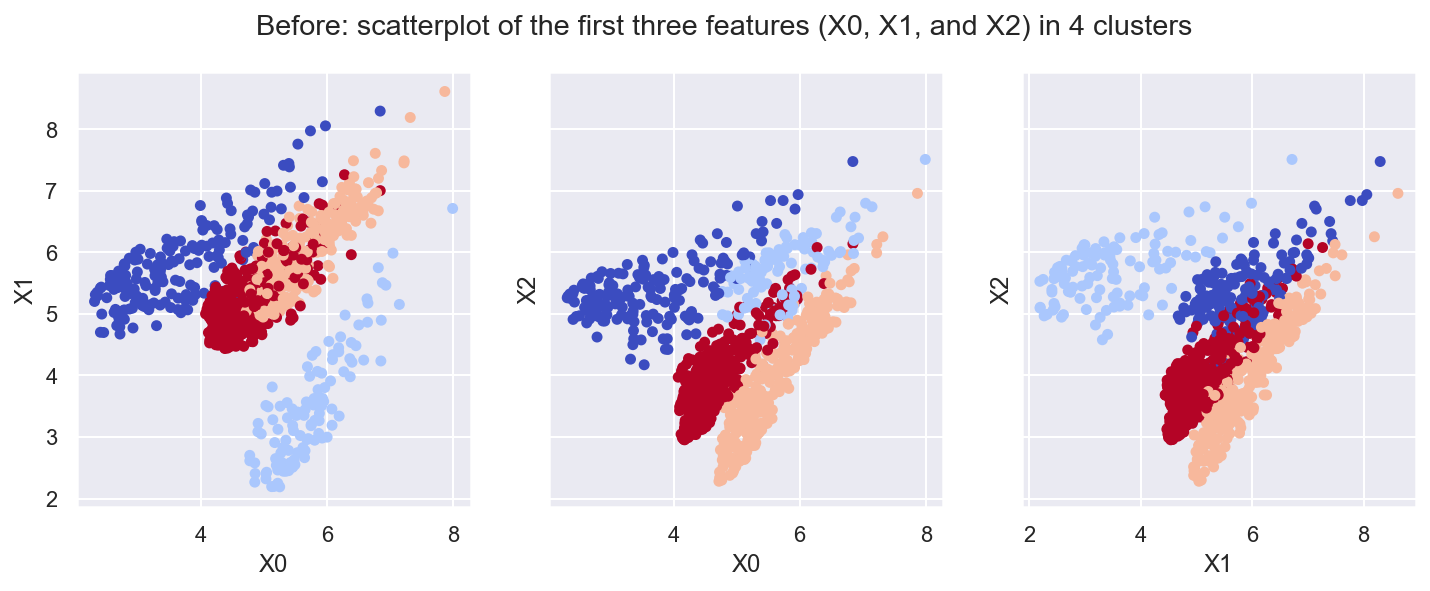

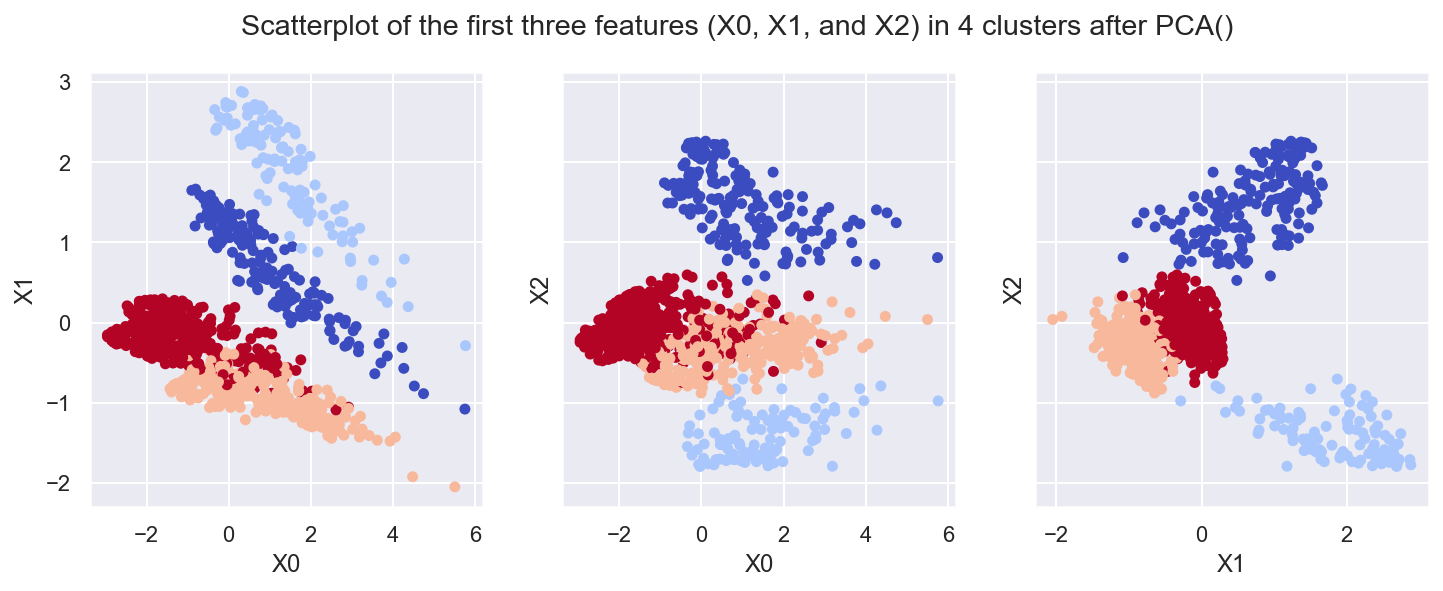

In [21]:
dim_reduction(X, PCA())

The clusters are better separated, although not ideally, after PCA procedure.